# 市场情绪指标

选取六个情绪指标构建投资者情绪指数

* 封闭式基金折价率：每月封闭式基金折价的市值加权平均数
* 可转债转股溢价率：每月可转债转股溢价率的加权平均数
* IPO发行数量：每月IPO发行数量
* IPO发行首日加权换手率：每月IPO首日换手率的加权平均数（去除）
* IPO发行首日加权回报率：每月IPO首日回报率的加权平均数（去除）
* 消费者信心指数
* 基金发行总份额

单个分散的情绪指标只能从市场的某一个方面反应出投资者的情绪，难以反应出整体市场情绪。比如封闭式基金折价率反应的是投资者个体的情绪状况，而基金仓位则反应了机构投资者的情绪状况。采用主成分提取法可以克服单个指标不能全面反应市场整体情绪的缺点，将使用的多个指标中所包含的复杂因素最终归结为一两个因素，使问题得以简化。

因此，我们可以利用主成分分析法将六个情绪指标归结为一个主成分，月度数据通过主成分分析方法归结的第一主成分称为情绪指数，月度变化数据通过主成分分析法归结的第一主成分称为情绪变化指数。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
import pyodbc
from sklearn import preprocessing, decomposition
%matplotlib inline

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
conn_param = 'DRIVER={SQL Server}; \
              SERVER=10.0.185.138; \
              DATABASE=JYDB; \
              UID=js_dev; \
              PWD=js_dev'

In [5]:
conn = pyodbc.connect(conn_param)

## 封闭式基金折价率

In [6]:
query = 'SELECT ar.MainCode, nv.InfoPublDate, nv.DiscountRatio \
         FROM MF_FundArchives as ar, MF_NetValue as nv \
         WHERE ar.InnerCode = nv.InnerCode \
             AND (ar.[Type] = 1 OR ar.[Type] = 6) \
             AND nv.InfoPublDate >= \'2000-01-01\''

In [7]:
df = pd.read_sql_query(query, con=conn)

In [8]:
df.head()

,MainCode,InfoPublDate,DiscountRatio
0,184708,2000-07-24,-0.475875
1,184708,2000-07-31,-0.408451
2,184708,2000-08-07,-0.467391
3,184708,2000-08-14,-0.458187
4,184708,2000-08-21,-0.467377


In [9]:
df = df.dropna()

In [10]:
discount = df.pivot_table('DiscountRatio', index=['InfoPublDate', 'MainCode']).unstack()

In [11]:
discount = discount.mean(axis=1).resample('M').mean()

In [12]:
discount = pd.DataFrame(discount, columns=[u'封闭式基金折价率'])

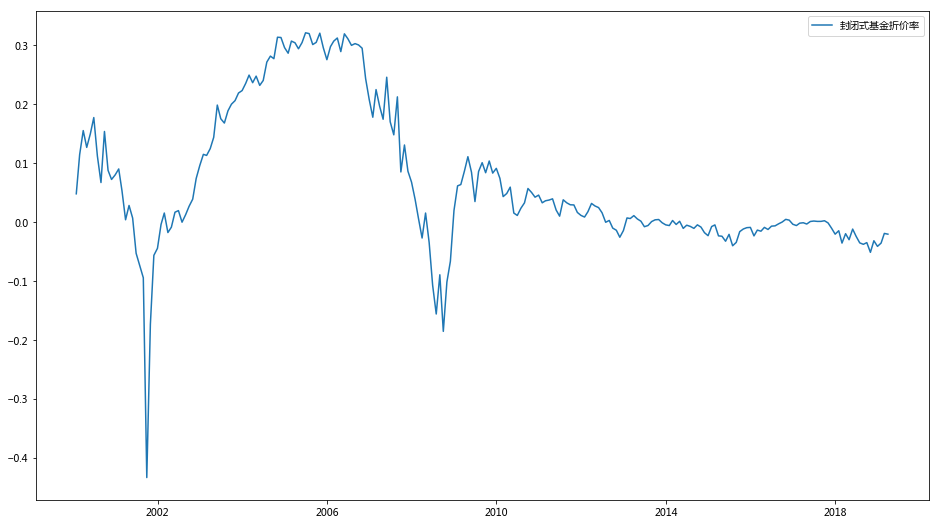

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(discount, label=u'封闭式基金折价率')
ax.legend();

## 可转债转股溢价率

In [14]:
query = 'SELECT b.InnerCode, b.TradingDay, b.TurnoverValue, b.ConvertPremiumRate \
         FROM Bond_ConBDExchangeQuote as b \
         WHERE b.TradingDay >= \'2000-01-01\' \
         ORDER BY b.TradingDay'

In [15]:
df = pd.read_sql_query(query, con=conn)

In [16]:
df.tail()

,InnerCode,TradingDay,TurnoverValue,ConvertPremiumRate
123793,166055,2019-03-21,4.140758e+07,-0.168501
123794,179362,2019-03-21,4.421808e+06,14.462245
123795,179767,2019-03-21,1.230648e+06,32.579331
123796,165714,2019-03-21,9.605904e+06,6.294226
123797,131084,2019-03-21,1.014265e+07,49.364919


In [17]:
weight = df.pivot_table('TurnoverValue', index=['TradingDay', 'InnerCode']).unstack()

In [18]:
weight = weight.div(weight.sum(axis=1), axis=0)

In [19]:
premium = df.pivot_table('ConvertPremiumRate', index=['TradingDay', 'InnerCode']).unstack()

In [20]:
premium = pd.DataFrame((premium * weight.values).sum(axis=1), columns=[u'可转债转股溢价率'])

In [21]:
premium = premium.resample('M').mean()

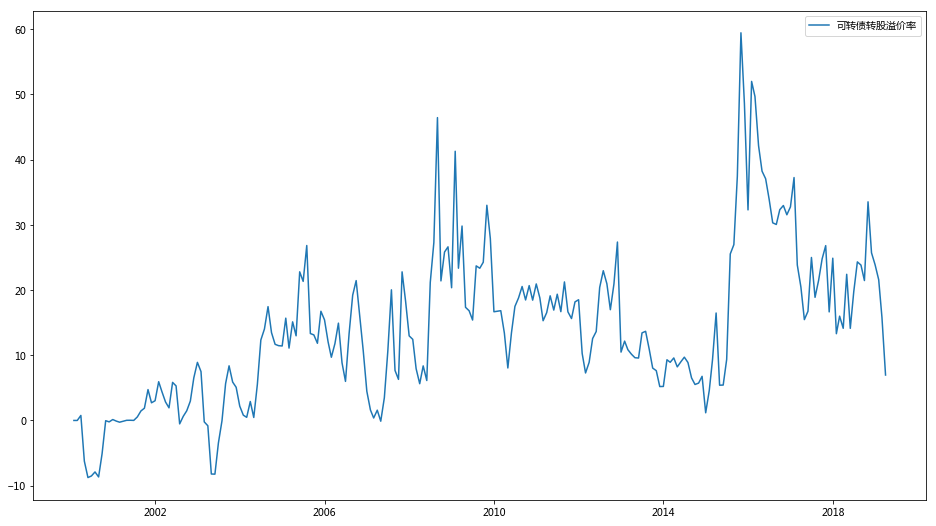

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(premium, label=u'可转债转股溢价率')
ax.legend()

## IPO发行数量

In [23]:
query = 'SELECT ipo.InitialInfoPublDate, ipo.InnerCode \
         FROM LC_AShareIPO as ipo \
         WHERE ipo.InitialInfoPublDate >= \'2000-01-01\''

In [24]:
df = pd.read_sql_query(query, con=conn)

In [25]:
df.head()

,InitialInfoPublDate,InnerCode
0,2000-03-22,111
1,2000-07-06,116
2,2000-06-29,117
3,2004-01-05,118
4,2000-07-19,119


In [26]:
ipo = df.groupby('InitialInfoPublDate').size()

In [27]:
ipo = ipo.resample('M').sum()

In [28]:
ipo = pd.DataFrame(ipo, columns=[u'IPO发行数量'])

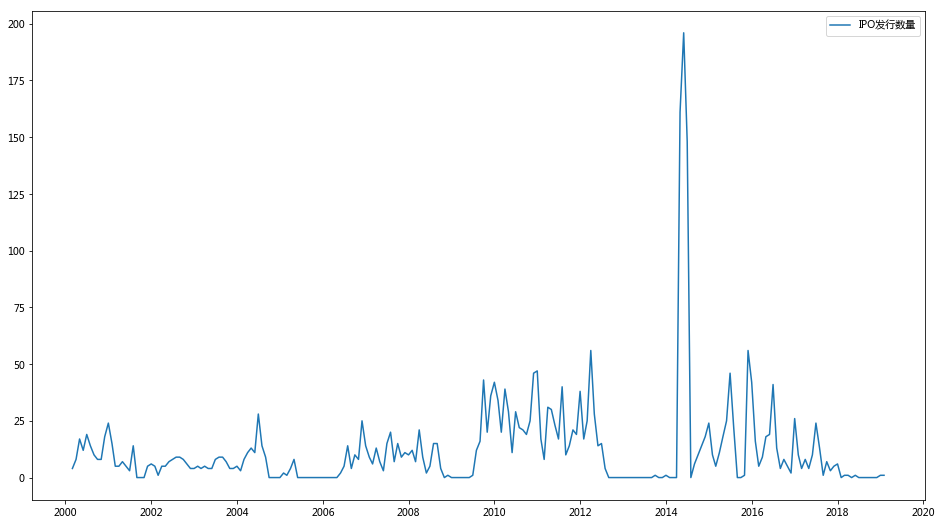

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(ipo, label=u'IPO发行数量')
ax.legend()

## 消费者信心指数

In [30]:
data = w.edb('M0012303', '2000-01-01', '2019-02-01')

In [31]:
confidence = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[u'消费者信心指数'])

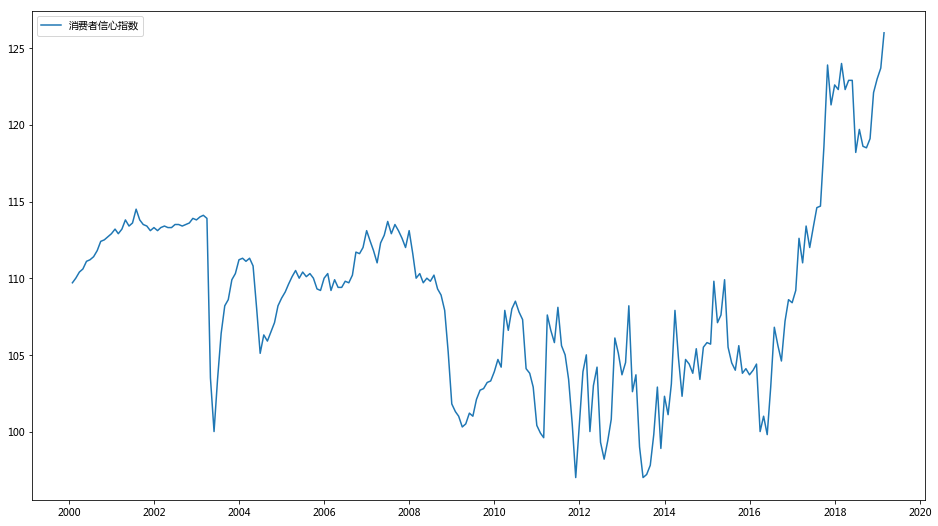

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(confidence, label=u'消费者信心指数')
ax.legend()

## 基金发行量

In [33]:
query = 'SELECT ar.SecurityCode, f.InitialInfoPublDate, f.ShareIssued \
         FROM MF_IssueAndListing as f, MF_FundArchives as ar \
         WHERE f.InnerCode = ar.InnerCode \
             AND (ar.FundTypeCode = 1101 OR ar.FundTypeCode = 1103) \
             AND f.InitialInfoPublDate >= \'2000-01-01\''

In [34]:
df = pd.read_sql_query(query, con=conn)

In [35]:
df.head()

,SecurityCode,InitialInfoPublDate,ShareIssued
0,184696,2000-04-19,210960000.0
1,184700,2001-11-23,200000009.0
2,184702,2000-05-10,268027448.0
3,184703,2000-06-27,233640000.0
4,184705,2000-05-12,200000000.0


In [36]:
fund_ipo = df.groupby('InitialInfoPublDate').sum()

In [37]:
fund_ipo.index = pd.to_datetime(fund_ipo.index)

In [38]:
fund_ipo = fund_ipo.sort_index().resample('M').sum()

In [39]:
fund_ipo.columns = [u'基金发行量']

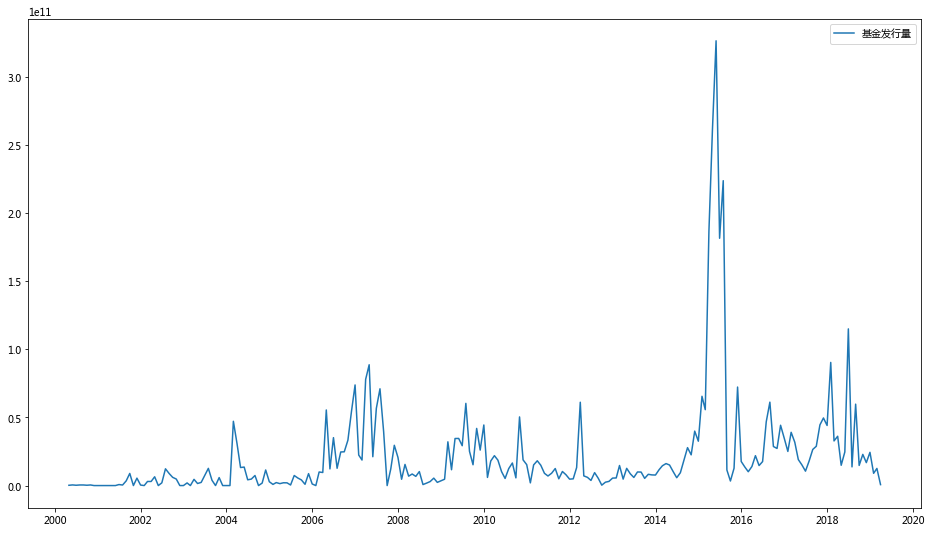

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(fund_ipo, label=u'基金发行量')
ax.legend()

# 预处理，正则化

In [98]:
discount.shape, premium.shape, ipo.shape, confidence.shape, fund_ipo.shape

((231, 1), (231, 1), (228, 1), (230, 1), (228, 1))

In [99]:
df = -discount.diff()

In [100]:
# df = df.merge(premium, left_index=True, right_index=True)
df = df.merge(ipo, left_index=True, right_index=True)
# df = df.merge(confidence.diff(), left_index=True, right_index=True)
df = df.merge(fund_ipo, left_index=True, right_index=True)

In [101]:
# df.to_excel(u'../data/情绪指标源数据.xlsx')

In [102]:
df = df.dropna()

In [103]:
df.head()

,封闭式基金折价率,IPO发行数量,基金发行量
2000-04-30,0.028497,17,210960000.0
2000-05-31,-0.022824,12,468027448.0
2000-06-30,-0.027796,19,233640000.0
2000-07-31,0.065315,14,428170566.0
2000-08-31,0.044934,10,432748084.0


In [115]:
df = df[df.index >= '2009-01-01']

In [116]:
scaler = preprocessing.StandardScaler().fit(df)

In [117]:
X = scaler.transform(df)

# PCA提取第一主成分

In [118]:
k = 3
pca = decomposition.PCA(n_components=k)

In [119]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [120]:
pca.components_

array([[ 0.65343149,  0.30549721,  0.69260287],
       [-0.35224082,  0.93256731, -0.07902286],
       [-0.67004006, -0.19232698,  0.71697744]])

In [121]:
pd.DataFrame(pca.components_, index=['comp %d'%(i+1) for i in range(k)]).to_excel(u'../data/PCA向量.xlsx')

In [122]:
pca.explained_variance_ratio_

array([0.35721192, 0.33171774, 0.31107034])

In [123]:
y = pca.transform(X)

In [124]:
comp = pd.DataFrame(y, index=df.index, columns=['comp %d'%(i+1) for i in range(k)])

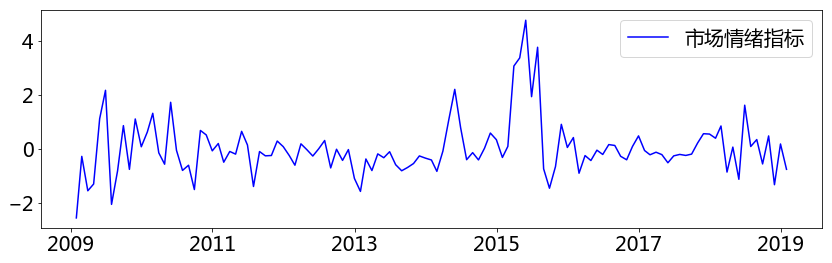

In [130]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(comp['comp 1'], color='blue', label=u'市场情绪指标')
ax.legend(fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
# axx = ax.twinx()
# axx.plot(df[u'IPO发行数量'], color='red')

In [96]:
comp.to_excel(u'../data/情绪指标主成分.xlsx')